<a href="https://colab.research.google.com/github/CWill22/NeuralHW13/blob/main/HW13_WaveNet_Demo_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # cuda means it is using a GPU
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Generate a 1-second sine wave (440Hz)
def generate_sine_wave(seq_len=16000, freq=440, sample_rate=16000):
    t = np.linspace(0, 1, seq_len)
    return np.sin(2 * np.pi * freq * t).astype(np.float32)

# Prepare input and target tensors
wave = generate_sine_wave()
X = torch.tensor(wave[:-1]).unsqueeze(0).unsqueeze(0)  # (batch, channel, time)
Y = torch.tensor(wave[1:]).unsqueeze(0).unsqueeze(0)   # shifted target

X, Y = X.to(device), Y.to(device)

In [ ]:
# Causal Convolution Layer
class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super().__init__()
        self.pad = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size,
                              padding=self.pad, dilation=dilation)

    def forward(self, x):
        out = self.conv(x)
        return out[:, :, :-self.pad]

# Mini WaveNet Model
class SimpleWaveNet(nn.Module):
    def __init__(self, residual_channels=32, skip_channels=64, dilation_depth=5):
        super().__init__()
        self.dilated_layers = nn.ModuleList()
        self.skip_conns = nn.ModuleList()

        for i in range(dilation_depth):
            dilation = 2 ** i
            self.dilated_layers.append(CausalConv1d(1 if i == 0 else residual_channels,
                                                    residual_channels, kernel_size=2, dilation=dilation))
            self.skip_conns.append(nn.Conv1d(residual_channels, skip_channels, 1))

        self.output = nn.Sequential(
            nn.ReLU(),
            nn.Conv1d(skip_channels, skip_channels, 1),
            nn.ReLU(),
            nn.Conv1d(skip_channels, 1, 1)
        )

    def forward(self, x):
        skip = 0
        for layer, skip_conn in zip(self.dilated_layers, self.skip_conns):
            x = torch.tanh(layer(x))
            skip += skip_conn(x)
        return self.output(skip)

In [ ]:
model = SimpleWaveNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Training
for epoch in range(2):
    model.train()
    optimizer.zero_grad()
    output = model(X)
    loss = loss_fn(output, Y)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")


Epoch 1, Loss: 0.538150
Epoch 2, Loss: 0.472624


In [ ]:
# Generate an audio sample step-by-step
model.eval()
initial_input = X[:, :, :1]  # one sample to start
generated = [initial_input.squeeze().item()]

with torch.no_grad():
    current_input = initial_input
    for _ in range(1000):
        out = model(current_input)
        next_sample = out[:, :, -1:].detach()
        generated.append(next_sample.squeeze().item())
        current_input = torch.cat([current_input, next_sample], dim=2)

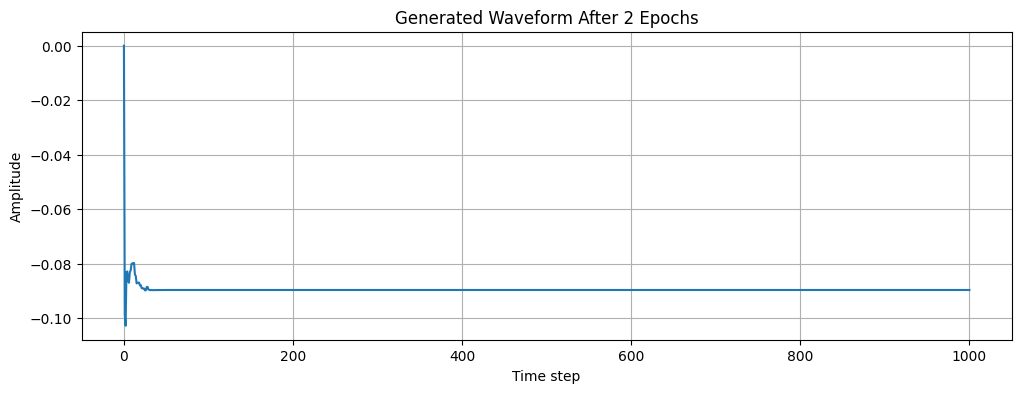

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(generated)
plt.title("Generated Waveform After 2 Epochs")
plt.xlabel("Time step")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [ ]:
from IPython.display import Audio
audio_np = np.array(generated)
audio_np = audio_np / np.max(np.abs(audio_np))
sample_rate = 16000
Audio(audio_np, rate=sample_rate)

## Quality:
The quality seems very poor as the amplitude changes only in the first couple milliseconds, and it is not spread amoung the full time of the audio clip. This causes it to only be able to make a quick sound, that does not resemble anything.


### Suggestions to Improve:
- I would increase the number of epochs, as 2 is not nearly enough for any meaningful training to occur.
- I would increase the length of the training data and the output to be multiple seconds so that it can capture an actual sound, like a word or sentence being spoken.
-Normalizing both the inputs and the outputs to be [-1,1] would help improve training even more.

